In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(365)
from numpy import mean
import pickle
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX 



### Read in Datasets for all boroughs

In [2]:
all_df = pickle.load(open('./data/final_cleaned_data/all_cleaned_data.pkl','rb'))
bronx_df = pickle.load(open('./data/final_cleaned_data/bronx_cleaned_data.pkl','rb'))
brooklyn_df = pickle.load(open('./data/final_cleaned_data/brooklyn_cleaned_data.pkl','rb'))
manhattan_df = pickle.load(open('./data/final_cleaned_data/manhattan_cleaned_data.pkl','rb'))
queens_df = pickle.load(open('./data/final_cleaned_data/queens_cleaned_data.pkl','rb'))
staten_df = pickle.load(open('./data/final_cleaned_data/staten_cleaned_data.pkl','rb'))

In [3]:
# Manhattan
man_precovid_df = manhattan_df[:'2020-03-21']
man_covid_df = manhattan_df['2020-03-22':]

#Queens
queens_precovid_df = queens_df[:'2020-03-21']
queens_covid_df = queens_df['2020-03-21':]

# Brooklyn
brooklyn_precovid_df = brooklyn_df[:'2020-03-21']
brooklyn_covid_df = brooklyn_df['2020-03-21':]

# Bronx
bronx_precovid_df = bronx_df[:'2020-03-21']
bronx_covid_df = bronx_df['2020-03-21':]

# Staten Island
staten_precovid_df = staten_df[:'2020-03-21']
staten_covid_df = staten_df['2020-03-21':]

## Train Test Split our data so we have train set which is using 70% of the precovid/covid cases and 30% of latter. (it's sequential)

In [4]:
## PRECOVID TRAIN(70%), TEST SET(30%)
X = man_precovid_df.values
size = int(len(X) * 0.70)
man_precovid_train, man_precovid_test  = man_precovid_df[:size], man_precovid_df[size:]
queens_precovid_train, queens_precovid_test  = queens_precovid_df[:size], queens_precovid_df[size:]
brooklyn_precovid_train, brooklyn_precovid_test  = brooklyn_precovid_df[:size], brooklyn_precovid_df[size:]
bronx_precovid_train, bronx_precovid_test  = bronx_precovid_df[:size], bronx_precovid_df[size:]
staten_precovid_train, staten_precovid_test  = staten_precovid_df[:size], staten_precovid_df[size:]

## COVID  (70%), TEST (30%)
man_covid_train, man_covid_test = man_covid_df[:size], man_covid_df[size:]
queens_covid_train, queens_covid_test = queens_covid_df[:size], queens_covid_df[size:]
brooklyn_covid_train, brooklyn_covid_test = brooklyn_covid_df[:size], brooklyn_covid_df[size:]
bronx_covid_train, bronx_covid_test = bronx_covid_df[:size], bronx_covid_df[size:]
staten_covid_train, staten_covid_test = staten_covid_df[:size], staten_covid_df[size:]

### placeholder for the RMSE scores: I will bring the results from 03.Baseline_Models

In [5]:
placeholder_man = pickle.load(open('./data/pickled/placeholder_manhattan.pkl','rb'))
placeholder_queens = pickle.load(open('./data/pickled/placeholder_queens.pkl','rb'))
placeholder_brooklyn = pickle.load(open('./data/pickled/placeholder_brooklyn.pkl','rb'))
placeholder_bronx = pickle.load(open('./data/pickled/placeholder_bronx.pkl','rb'))
placeholder_staten = pickle.load(open('./data/pickled/placeholder_staten.pkl','rb'))
placeholder_man

{'naive_forecast_baseline': 4805.149712683199,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2058.2126193852323,
 'rmse_holt_winter': 621.80601732219}

# Manhattan

## PRE-COVID:

### Dickey-Fuller Test to check if our data is stationay for Manhattan:

In [6]:
## CHECK TO SEE IF OUR DATA IS STATINONARY
ad_test = adfuller(man_precovid_train['count'])
print('ADF Statistic: %f' % ad_test[0])
print('p-value: %f' % ad_test[1])
print('Critical Values:')
for key, value in ad_test[4].items():
    print('\t%s: %.3f' % (key, value))
print('number of observations used:', ad_test[3])
print('lags used:', ad_test[2])

ADF Statistic: -7.143041
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
number of observations used: 4923
lags used: 32


We can see here that our p-value is less than our alpha value and also test statistic is less than the critical value, so we can reject the null hypothesis. (null hypothesis is the data is not stationary). So our data is stationary. We do not need to difference our data.

## ACF AND PACF

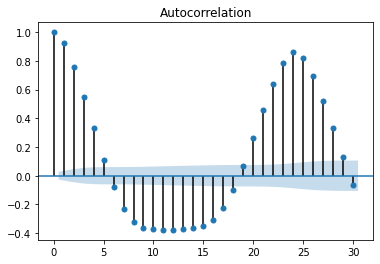

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(man_precovid_train['count'], alpha=.05, lags=30);

Here we can see that our acf gives us MA of 5. 

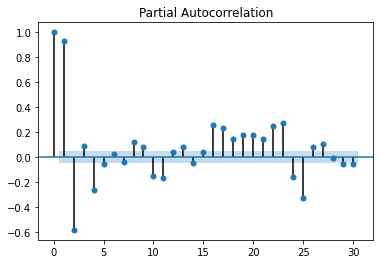

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(man_precovid_test['count'], alpha=.025, lags=30);

AR of 2 will be used

#### ARIMA #1:

In [9]:
model = ARIMA(man_precovid_train, order=(2,0,5)) 
arima_1 = model.fit(disp=0)
print(arima_1.summary())

                              ARMA Model Results                              
Dep. Variable:                  count   No. Observations:                 4956
Model:                     ARMA(2, 5)   Log Likelihood              -41962.570
Method:                       css-mle   S.D. of innovations           1150.246
Date:                Tue, 10 Nov 2020   AIC                          83943.140
Time:                        15:19:56   BIC                          84001.716
Sample:                    06-01-2019   HQIC                         83963.679
                         - 12-24-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8342.1385     87.415     95.431      0.000    8170.808    8513.469
ar.L1.count     1.7598      0.012    144.278      0.000       1.736       1.784
ar.L2.count    -0.8433      0.011    -79.991    

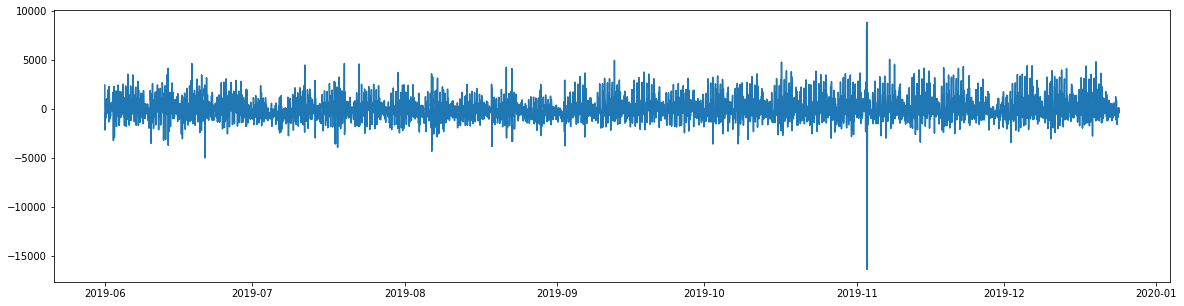

In [10]:
plt.figure(figsize=(20,5))  # plot the residuals

residuals = pd.DataFrame(arima_1.resid)
plt.plot(residuals)
plt.show()

We can see from our describe method that our mean is 0.46 which means that there may be bias as. there is non-zero in the residuals

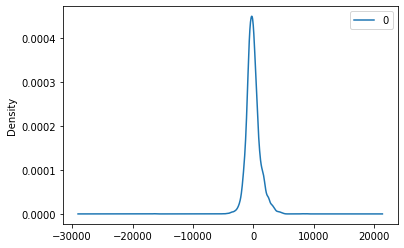

In [11]:
residuals = pd.DataFrame(arima_1.resid)  # plot the residuals distribution
residuals.plot(kind='kde',)
plt.show()

In [12]:
2

2

In [13]:
# evaluate the model on the training data
train_arma_rmse = np.sqrt(np.mean(arima_1.resid**2))  # check the RMSE scores
placeholder_man['arima_1'] = train_arma_rmse

placeholder_man

{'naive_forecast_baseline': 4805.149712683199,
 'moving_average_baseline': 4131.2698664755535,
 'rmse_holt_linear': 2058.2126193852323,
 'rmse_holt_winter': 621.80601732219,
 'arima_1': 1150.9311838128647}

In [14]:
# get predictions for the test data
predictions = arima_1.predict(start=man_precovid_test.index[0], end=man_precovid_test.index[-1])
residuals = man_precovid_test['count'] - predictions  # get the residuals
test_arma_rmse = np.sqrt(np.mean(residuals**2))
print(test_arma_rmse)

4551.392016007548


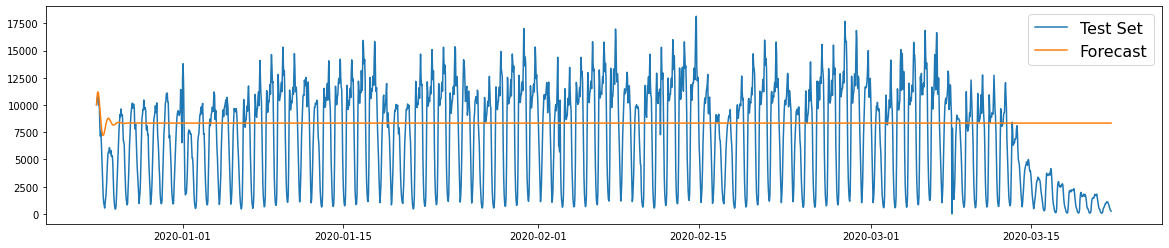

In [15]:
plt.figure(figsize=(20,4))  # plot the predictions and the actual data

plt.plot(man_precovid_test)
plt.plot(predictions)

plt.legend(('Test Set', 'Forecast'), fontsize=16)

Seems like we are using mean to forecast. This is not appropriate as we want to find mroe diversity

## ARIMA 2: using PMDARIMA library

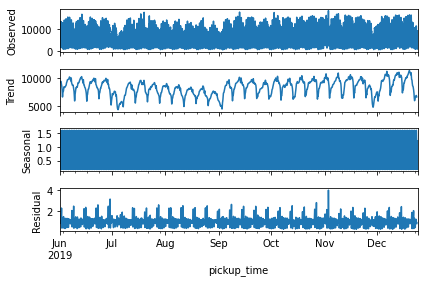

In [16]:
result = seasonal_decompose(man_precovid_train['count'],  model ='multiplicative') 
result.plot();

In [17]:
stepwise_fit = auto_arima(man_precovid_df['count'], start_p = 0, start_q = 0, 
                          max_p = 10, max_q = 10, m = 12, 
                          start_P = 0, seasonal = False, 
                          d = None, D = None, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
stepwise_fit.summary() 


Fit ARIMA: order=(0, 1, 0); AIC=124952.548, BIC=124966.277, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=122014.889, BIC=122035.484, Fit time=0.041 seconds
Fit ARIMA: order=(0, 1, 1); AIC=121928.465, BIC=121949.060, Fit time=0.095 seconds
Fit ARIMA: order=(1, 1, 1); AIC=121583.613, BIC=121611.073, Fit time=1.382 seconds
Fit ARIMA: order=(1, 1, 2); AIC=121511.251, BIC=121545.575, Fit time=3.620 seconds
Fit ARIMA: order=(2, 1, 3); AIC=119923.669, BIC=119971.723, Fit time=3.991 seconds
Fit ARIMA: order=(1, 1, 3); AIC=120970.828, BIC=121012.017, Fit time=4.018 seconds
Fit ARIMA: order=(3, 1, 3); AIC=119908.068, BIC=119962.987, Fit time=4.377 seconds
Fit ARIMA: order=(3, 1, 2); AIC=120710.417, BIC=120758.472, Fit time=4.770 seconds
Fit ARIMA: order=(3, 1, 4); AIC=119837.711, BIC=119899.495, Fit time=4.927 seconds
Fit ARIMA: order=(4, 1, 5); AIC=119367.764, BIC=119443.278, Fit time=16.285 seconds
Fit ARIMA: order=(3, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(5

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7079
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -59621.885
Method:                       css-mle   S.D. of innovations           1099.831
Date:                Tue, 10 Nov 2020   AIC                         119267.771
Time:                        15:21:24   BIC                         119350.149
Sample:                             1   HQIC                        119296.141
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4649      4.425     -0.331      0.741     -10.138       7.209
ar.L1.D.y      1.5708      0.021     74.179      0.000       1.529       1.612
ar.L2.D.y     -1.2785      0.029    -43.635      0.000      -1.336      -1.221
ar.L3.D.y      1.6002      0.021     76.228      0.000       1.559       1.641
ar.L4.D.y     -1.2460      0.029    -42.386      0.000      -1.304      -1.188
ar.L5.D.y      0.2187      0.021     10.530      0.000       0.178       0.259
ma.L1.D.y     -1.0477      0.019    -53.757      0.000      -1.086      -1.009
ma.L2.D.y      0.4165      0.026     16.048      0.000       0.366       0.467
ma.L3.D.y     -1.0819      0.017    -62.830      0.000      -1.116      -1.048
ma.L4.D.y      0.4263      0.027     15.735      0.000       0.373       0.479
ma.L5.D.y      0.3324      0.018     18.829      0.000       0.298       0.367
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2592           -0.9665j            1.0006           -0.2917
AR.2           -0.2592           +0.9665j            1.0006            0.2917
AR.3            1.0047           -0.2762j            1.0419           -0.0427
AR.4            1.0047           +0.2762j            1.0419            0.0427
AR.5            4.2070           -0.0000j            4.2070           -0.0000
MA.1           -0.2655           -0.9709j            1.0066           -0.2925
MA.2           -0.2655           +0.9709j            1.0066            0.2925
MA.3            1.0234           -0.1169j            1.0301           -0.0181
MA.4            1.0234           +0.1169j            1.0301            0.0181
MA.5           -2.7988           -0.0000j            2.7988           -0.5000
-----------------------------------------------------------------------------
"""

In [18]:
model_2 = SARIMAX(man_precovid_df['count'], order = (5, 0, 2)) 
  
result = model_2.fit() 
result.summary() 

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  count   No. Observations:                 7080
Model:               SARIMAX(5, 0, 2)   Log Likelihood              -60472.968
Date:                Tue, 10 Nov 2020   AIC                         120961.937
Time:                        15:21:37   BIC                         121016.857
Sample:                    06-01-2019   HQIC                        120980.851
                         - 03-21-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2521      0.006    215.385      0.000       1.241       1.263
ar.L2         -1.0661      0.009   -119.846      0.000      -1.084      -1.049
ar.L3          1.4687      0.005    270.356      0.000       1.458       1.479
ar.L4         -0.8704      0.007   -119.311      0.000      -0.885      -0.856
ar.L5          0.2152      0.008     25.873      0.000       0.199       0.232
ma.L1          0.5285      0.002    223.001      0.000       0.524       0.533
ma.L2          0.9868      0.002    422.623      0.000       0.982       0.991
sigma2      1.573e+06   8.19e-09   1.92e+14      0.000    1.57e+06    1.57e+06
===================================================================================
Ljung-Box (Q):                     4231.02   Jarque-Bera (JB):             48705.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.67e+29. Standard errors may be unstable.
"""

Text(0.5, 1.0, 'Forecasting from December 24th to March 21st (before Covid Lockdown)')

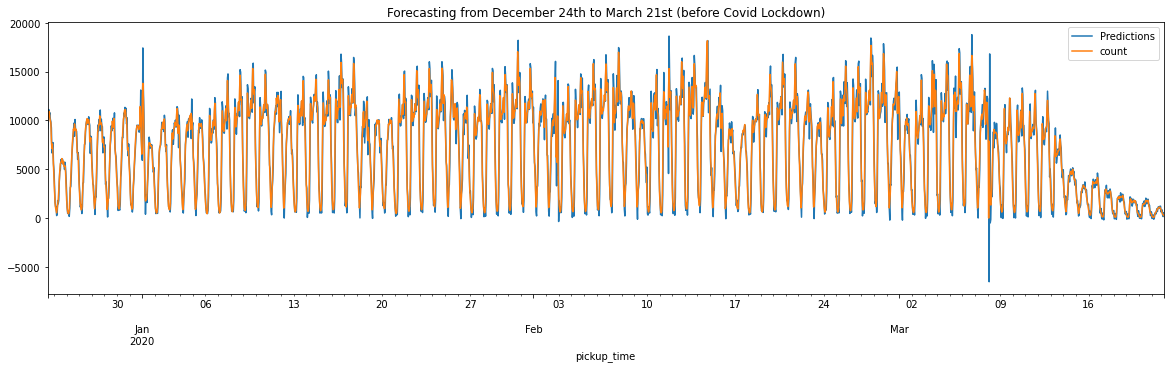

In [19]:
start = len(man_precovid_train) 
end = len(man_precovid_train) + len(man_precovid_test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
fig, ax = plt.subplots(figsize=(20, 5))
predictions.plot(legend = True) 
man_precovid_test['count'].plot(legend = True) 
plt.title('Forecasting from December 24th to March 21st (before Covid Lockdown)')

In [20]:
# Calculate root mean squared error 
print('RMSE for ARIMA#2:' ,rmse(man_precovid_test["count"], predictions))

placeholder_man['arima_2'] = rmse(man_precovid_test["count"], predictions) 

RMSE for ARIMA#2: 1285.9309899923312


Forecasting using ARIMA model

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


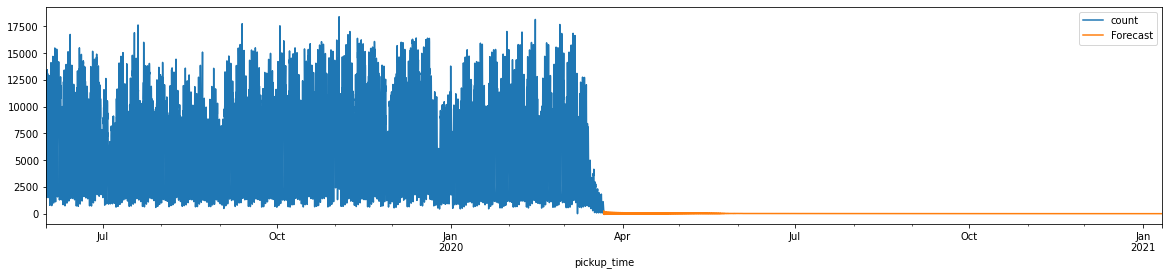

In [21]:
# Train the model on the full dataset 
model = SARIMAX(man_precovid_df['count'],  order = (5, 0, 2)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(man_precovid_df),  
                          end = (len(man_precovid_df)) * 2,  
                          typ='levels').rename('Forecast') 
  
# Plot the forecast values 
man_precovid_df['count'].plot(figsize = (20, 4), legend = True) 
forecast.plot(legend = True) 

## SARIMA

Since our ARIMA model was not forecasting well, let's see how our model does with seasonal order.

Instantiate a SARIMAX model without exogenous variable then fit the model and view the summary

In [22]:
man_precovid_df

,count
pickup_time,
2019-06-01 00:00:00,10744
2019-06-01 01:00:00,8371
2019-06-01 02:00:00,6212
2019-06-01 03:00:00,4319
2019-06-01 04:00:00,2921
...,...
2020-03-21 19:00:00,709
2020-03-21 20:00:00,539
2020-03-21 21:00:00,386


In [23]:
import pmdarima as pm

sarima_1 = auto_arima(man_precovid_df['count'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 24, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 

sarima_1.summary()

In [ ]:
sarima_1.summary()

In [ ]:
sarima_model = SARIMAX(man_precovid_train, order=(2, 0, 1), seasonal_order=(2, 1, 2, 8))
result = sarima_model.fit()

In [ ]:
result.summary()

In [ ]:
start = len(man_precovid_train) 
end = len(man_precovid_train) + len(man_precovid_test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
man_precovid_test['count'].plot(legend = True) 

In [ ]:
rmse(man_precovid_test['count'], predictions) 

In [ ]:
# Train the model on the full dataset 
model = SARIMAX(man_precovid_df['count'],  
                        order = (2, 0, 1),  
                        seasonal_order =(2, 1, 2, 8)) 
result = model.fit() 
  
# Forecast for the next 3 years 
forecast = result.predict(start = len(man_precovid_df),  
                          end = (len(man_precovid_df)-1) + 300,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
man_precovid_df['count'].plot(figsize = (20, 5), legend = True) 
forecast.plot(legend = True) 

It seems like our model wil predict that by April, the number of pickups will pick back up but remember, we are using precovid data to forecast so the model is reflecting precovid times only. 